In [ ]:
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html
!pip install --upgrade  cython
!git clone https://github.com/microsoft/qlib.git 
%cd qlib
!python setup.py install
!python scripts/get_data.py qlib_data --target_dir ~/.qlib/qlib_data/cn_data --region cn --version v2
%cd ..
!pip install -r requirements.txt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import copy
import json
import argparse
import datetime
import collections
import numpy as np
import pandas as pd
from tqdm import tqdm
import qlib
from qlib.config import REG_CN
provider_uri = "~/.qlib/qlib_data/cn_data"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_CN)
from qlib.data.dataset import DatasetH
from qlib.data.dataset.handler import DataHandlerLP
from torch.utils.tensorboard import SummaryWriter
from qlib.contrib.model.pytorch_lstm import LSTMModel
from src.model import MLP, HIST
from src.utils import metric_fn, mse
from src.dataloader import DataLoader

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

EPS = 1e-12

In [ ]:

def get_model(model_name):

    if model_name.upper() == 'MLP':
        return MLP

    if model_name.upper() == 'LSTM':
        return LSTMModel

    if model_name.upper() == 'HIST':
        return HIST

    raise ValueError('unknown model name `%s`'%model_name)


def average_params(params_list):
    assert isinstance(params_list, (tuple, list, collections.deque))
    n = len(params_list)
    if n == 1:
        return params_list[0]
    new_params = collections.OrderedDict()
    keys = None
    for i, params in enumerate(params_list):
        if keys is None:
            keys = params.keys()
        for k, v in params.items():
            if k not in keys:
                raise ValueError('the %d-th model has different params'%i)
            if k not in new_params:
                new_params[k] = v / n
            else:
                new_params[k] += v / n
    return new_params



def loss_fn(pred, label, config):
    mask = ~torch.isnan(label)
    return mse(pred[mask], label[mask])


global_log_file = None
def pprint(*config):
    # print with UTC+8 time
    time = '['+str(datetime.datetime.utcnow()+
                   datetime.timedelta(hours=8))[:19]+'] -'
    print(time, *config, flush=True)

    if global_log_file is None:
        return
    with open(global_log_file, 'a') as f:
        print(time, *config, flush=True, file=f)


global_step = -1
def train_epoch(epoch, model, optimizer, train_loader, writer, config, stock2concept_matrix = None):

    global global_step

    model.train()

    for i, slc in tqdm(train_loader.iter_batch(), total=train_loader.batch_length):
        global_step += 1
        feature, label, market_value , stock_index, _ = train_loader.get(slc)
        if config.model_name == 'HIST':
            pred = model(feature, stock2concept_matrix[stock_index], market_value)
        else:
            pred = model(feature)
        loss = loss_fn(pred, label, config)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 3.)
        optimizer.step()


def test_epoch(epoch, model, test_loader, writer, config, stock2concept_matrix=None, prefix='Test'):

    model.eval()

    losses = []
    preds = []

    for i, slc in tqdm(test_loader.iter_daily(), desc=prefix, total=test_loader.daily_length):

        feature, label, market_value, stock_index, index = test_loader.get(slc)

        with torch.no_grad():
            if config.model_name == 'HIST':
                pred = model(feature, stock2concept_matrix[stock_index], market_value)
            else:
                pred = model(feature)
            loss = loss_fn(pred, label, config)
            preds.append(pd.DataFrame({ 'score': pred.cpu().numpy(), 'label': label.cpu().numpy(), }, index=index))

        losses.append(loss.item())
    preds = pd.concat(preds, axis=0)
    precision, recall, ic, rank_ic = metric_fn(preds)
    scores = ic


    writer.add_scalar(prefix+'/Loss', np.mean(losses), epoch)
    writer.add_scalar(prefix+'/std(Loss)', np.std(losses), epoch)
    writer.add_scalar(prefix+'/'+config.metric, np.mean(scores), epoch)
    writer.add_scalar(prefix+'/std('+config.metric+')', np.std(scores), epoch)

    return np.mean(losses), scores, precision, recall, ic, rank_ic

def inference(model, data_loader, stock2concept_matrix=None):

    model.eval()

    preds = []
    for i, slc in tqdm(data_loader.iter_daily(), total=data_loader.daily_length):

        feature, label, market_value, stock_index, index = data_loader.get(slc)
        with torch.no_grad():
            if config.model_name == 'HIST':
                pred = model(feature, stock2concept_matrix[stock_index], market_value)
            else:
                pred = model(feature)
            preds.append(pd.DataFrame({ 'score': pred.cpu().numpy(), 'label': label.cpu().numpy(),  }, index=index))

    preds = pd.concat(preds, axis=0)
    return preds


def create_loaders(config):

    start_time = datetime.datetime.strptime(config.train_start_date, '%Y-%m-%d')
    end_time = datetime.datetime.strptime(config.test_end_date, '%Y-%m-%d')
    train_end_time = datetime.datetime.strptime(config.train_end_date, '%Y-%m-%d')

    hanlder = {'class': 'Alpha360', 'module_path': 'qlib.contrib.data.handler', 'kwconfig': {'start_time': start_time, 'end_time': end_time, 'fit_start_time': start_time, 'fit_end_time': train_end_time, 'instruments': config.data_set, 'infer_processors': [{'class': 'RobustZScoreNorm', 'kwconfig': {'fields_group': 'feature', 'clip_outlier': True}}, {'class': 'Fillna', 'kwconfig': {'fields_group': 'feature'}}], 'learn_processors': [{'class': 'DropnaLabel'}, {'class': 'CSRankNorm', 'kwconfig': {'fields_group': 'label'}}], 'label': ['Ref($close, -1) / $close - 1']}}
    segments =  { 'train': (config.train_start_date, config.train_end_date), 'valid': (config.valid_start_date, config.valid_end_date), 'test': (config.test_start_date, config.test_end_date)}
    dataset = DatasetH(hanlder,segments)

    df_train, df_valid, df_test = dataset.prepare( ["train", "valid", "test"], col_set=["feature", "label"], data_key=DataHandlerLP.DK_L,)
    import pickle5 as pickle
    with open(config.market_value_path, "rb") as fh:
        df_market_value = pickle.load(fh)
    #df_market_value = pd.read_pickle(config.market_value_path)
    df_market_value = df_market_value/1000000000
    stock_index = np.load(config.stock_index, allow_pickle=True).item()

    start_index = 0
    slc = slice(pd.Timestamp(config.train_start_date), pd.Timestamp(config.train_end_date))
    df_train['market_value'] = df_market_value[slc]
    df_train['market_value'] = df_train['market_value'].fillna(df_train['market_value'].mean())
    df_train['stock_index'] = 733
    df_train['stock_index'] = df_train.index.get_level_values('instrument').map(stock_index).fillna(733).astype(int)

    train_loader = DataLoader(df_train["feature"], df_train["label"], df_train['market_value'], df_train['stock_index'], batch_size=config.batch_size, pin_memory=config.pin_memory, start_index=start_index, device = device)

    slc = slice(pd.Timestamp(config.valid_start_date), pd.Timestamp(config.valid_end_date))
    df_valid['market_value'] = df_market_value[slc]
    df_valid['market_value'] = df_valid['market_value'].fillna(df_train['market_value'].mean())
    df_valid['stock_index'] = 733
    df_valid['stock_index'] = df_valid.index.get_level_values('instrument').map(stock_index).fillna(733).astype(int)
    start_index += len(df_valid.groupby(level=0).size())

    valid_loader = DataLoader(df_valid["feature"], df_valid["label"], df_valid['market_value'], df_valid['stock_index'], pin_memory=True, start_index=start_index, device = device)
    
    slc = slice(pd.Timestamp(config.test_start_date), pd.Timestamp(config.test_end_date))
    df_test['market_value'] = df_market_value[slc]
    df_test['market_value'] = df_test['market_value'].fillna(df_train['market_value'].mean())
    df_test['stock_index'] = 733
    df_test['stock_index'] = df_test.index.get_level_values('instrument').map(stock_index).fillna(733).astype(int)
    start_index += len(df_test.groupby(level=0).size())

    test_loader = DataLoader(df_test["feature"], df_test["label"], df_test['market_value'], df_test['stock_index'], pin_memory=True, start_index=start_index, device = device)

    return train_loader, valid_loader, test_loader


In [ ]:
def experiment(config):
    seed = np.random.randint(1000000)
    np.random.seed(seed)
    torch.manual_seed(seed)
    suffix = "%s_dh%s_dn%s_drop%s_lr%s_bs%s_seed%s%s"%(
        config.model_name, config.hidden_size, config.num_layers, config.dropout,
        config.lr, config.batch_size, config.seed, config.annot
    )

    output_path = config.outdir
    if not output_path:
        output_path = './output/' + suffix
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    if not config.overwrite and os.path.exists(output_path+'/'+'info.json'):
        print('already runned, exit.')
        return

    writer = SummaryWriter(log_dir=output_path)

    global global_log_file
    global_log_file = output_path + '/' + config.name + '_run.log'

    pprint('create loaders...')
    train_loader, valid_loader, test_loader = create_loaders(config)

    stock2concept_matrix = np.load(config.stock2concept_matrix) 
    if config.model_name == 'HIST':
        stock2concept_matrix = torch.Tensor(stock2concept_matrix).to(device)

    all_precision = []
    all_recall = []
    all_ic = []
    all_rank_ic = []
    for times in range(config.repeat):
        pprint('create model...')
        if config.model_name == 'SFM':
            model = get_model(config.model_name)(d_feat = config.d_feat, output_dim = 32, freq_dim = 25, hidden_size = config.hidden_size, dropout_W = 0.5, dropout_U = 0.5, device = device)
        elif config.model_name == 'ALSTM':
            model = get_model(config.model_name)(config.d_feat, config.hidden_size, config.num_layers, config.dropout, 'LSTM')
        elif config.model_name == 'Transformer':
            model = get_model(config.model_name)(config.d_feat, config.hidden_size, config.num_layers, dropout=0.5)
        elif config.model_name == 'HIST':
            model = get_model(config.model_name)(d_feat = config.d_feat, num_layers = config.num_layers, K = config.K)
        else:
            model = get_model(config.model_name)(d_feat = config.d_feat, num_layers = config.num_layers)
        
        model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=config.lr)
        best_score = -np.inf
        best_epoch = 0
        stop_round = 0
        best_param = copy.deepcopy(model.state_dict())
        params_list = collections.deque(maxlen=config.smooth_steps)
        for epoch in range(config.n_epochs):
            pprint('Running', times,'Epoch:', epoch)

            pprint('training...')
            train_epoch(epoch, model, optimizer, train_loader, writer, config, stock2concept_matrix)
            torch.save(model.state_dict(), output_path+'/model.bin.e'+str(epoch))
            torch.save(optimizer.state_dict(), output_path+'/optimizer.bin.e'+str(epoch))

            params_ckpt = copy.deepcopy(model.state_dict())
            params_list.append(params_ckpt)
            avg_params = average_params(params_list)
            model.load_state_dict(avg_params)

            pprint('evaluating...')
            train_loss, train_score, train_precision, train_recall, train_ic, train_rank_ic = test_epoch(epoch, model, train_loader, writer, config, stock2concept_matrix, prefix='Train')
            val_loss, val_score, val_precision, val_recall, val_ic, val_rank_ic = test_epoch(epoch, model, valid_loader, writer, config, stock2concept_matrix, prefix='Valid')
            test_loss, test_score, test_precision, test_recall, test_ic, test_rank_ic = test_epoch(epoch, model, test_loader, writer, config, stock2concept_matrix, prefix='Test')

            pprint('train_loss %.6f, valid_loss %.6f, test_loss %.6f'%(train_loss, val_loss, test_loss))
            pprint('train_score %.6f, valid_score %.6f, test_score %.6f'%(train_score, val_score, test_score))
            # pprint('train_mse %.6f, valid_mse %.6f, test_mse %.6f'%(train_mse, val_mse, test_mse))
            # pprint('train_mae %.6f, valid_mae %.6f, test_mae %.6f'%(train_mae, val_mae, test_mae))
            pprint('train_ic %.6f, valid_ic %.6f, test_ic %.6f'%(train_ic, val_ic, test_ic))
            pprint('train_rank_ic %.6f, valid_rank_ic %.6f, test_rank_ic %.6f'%(train_rank_ic, val_rank_ic, test_rank_ic))
            pprint('Train Precision: ', train_precision)
            pprint('Valid Precision: ', val_precision)
            pprint('Test Precision: ', test_precision)
            pprint('Train Recall: ', train_recall)
            pprint('Valid Recall: ', val_recall)
            pprint('Test Recall: ', test_recall)
            model.load_state_dict(params_ckpt)

            if val_score > best_score:
                best_score = val_score
                stop_round = 0
                best_epoch = epoch
                best_param = copy.deepcopy(avg_params)
            else:
                stop_round += 1
                if stop_round >= config.early_stop:
                    pprint('early stop')
                    break

        pprint('best score:', best_score, '@', best_epoch)
        model.load_state_dict(best_param)
        torch.save(best_param, output_path+'/model.bin')

        pprint('inference...')
        res = dict()
        for name in ['train', 'valid', 'test']:

            pred= inference(model, eval(name+'_loader'), stock2concept_matrix)
            pred.to_pickle(output_path+'/pred.pkl.'+name+str(times))

            precision, recall, ic, rank_ic = metric_fn(pred)

            pprint(('%s: IC %.6f Rank IC %.6f')%(
                        name, ic.mean(), rank_ic.mean()))
            pprint(name, ': Precision ', precision)
            pprint(name, ': Recall ', recall)
            res[name+'-IC'] = ic
            # res[name+'-ICIR'] = ic.mean() / ic.std()
            res[name+'-RankIC'] = rank_ic
            # res[name+'-RankICIR'] = rank_ic.mean() / rank_ic.std()
        
        all_precision.append(list(precision.values()))
        all_recall.append(list(recall.values()))
        all_ic.append(ic)
        all_rank_ic.append(rank_ic)

        pprint('save info...')
        writer.add_hparams(
            vars(config),
            {
                'hparam/'+key: value
                for key, value in res.items()
            }
        )

        info = dict(
            config=vars(config),
            best_epoch=best_epoch,
            best_score=res,
        )
        default = lambda x: str(x)[:10] if isinstance(x, pd.Timestamp) else x
        with open(output_path+'/info.json', 'w') as f:
            json.dump(info, f, default=default, indent=4)
    pprint(('IC: %.4f (%.4f), Rank IC: %.4f (%.4f)')%(np.array(all_ic).mean(), np.array(all_ic).std(), np.array(all_rank_ic).mean(), np.array(all_rank_ic).std()))
    precision_mean = np.array(all_precision).mean(axis= 0)
    precision_std = np.array(all_precision).std(axis= 0)
    N = [1, 3, 5, 10, 20, 30, 50, 100]
    for k in range(len(N)):
        pprint (('Precision@%d: %.4f (%.4f)')%(N[k], precision_mean[k], precision_std[k]))

    pprint('finished.')

In [1]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [ ]:
config = dotdict({
    'model_name' : 'HIST',
    'd_feat' : 6, 
    'hidden_size' : 128,
    'num_layers':2,
    'dropout': 0.0, 
    'K':1, 
    'n_epochs' : 10, 
    'lr': 4e-3,
    'early_stop': 4, 
    'smooth_steps':2, 
    'metric':'IC', 
    'loss':'mse', 
    'repeat':10, 
    'data_set':'csi100', 
    'pin_memory':True, 
    'batch_size':-1, 
    'least_samples_num':1337.0, 
    'label':'', 
    'train_start_date':'2007-01-01', 
    'train_end_date':'2018-02-20', 
    'valid_start_date':'2018-02-20', 
    'valid_end_date':'2018-04-20', 
    'test_start_date':'2018-05-01', 
    'test_end_date':'2020-12-31', 
    'seed':3406,
    'annot':'',
    'market_value_path' : './data/csi300_market_value_07to20.pkl', 
    'stock2concept_matrix' : './data/csi300_stock2concept.npy',
    'stock_index': './data/csi300_stock_index.npy', 
    'outdir' : './output/csi300_HIST', 
    'overwrite' : True,
    'config':''
})




In [ ]:
experiment(config=config)

9.0

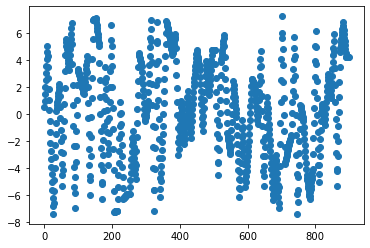

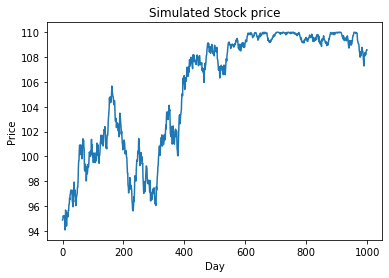

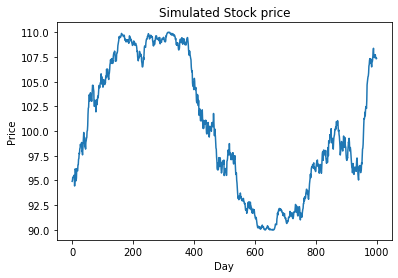

[759:MainThread](2021-11-28 19:25:30,310) INFO - qlib.Initialization - [config.py:393] - default_conf: client.
[759:MainThread](2021-11-28 19:25:30,311) WARNING - qlib.Initialization - [config.py:419] - redis connection failed(host=127.0.0.1 port=6379), DiskExpressionCache and DiskDatasetCache will not be used!
[759:MainThread](2021-11-28 19:25:30,931) INFO - qlib.Initialization - [__init__.py:57] - qlib successfully initialized based on client settings.
[759:MainThread](2021-11-28 19:25:30,931) INFO - qlib.Initialization - [__init__.py:59] - data_path={'__DEFAULT_FREQ': PosixPath('/root/.qlib/qlib_data/cn_data')}
Please install necessary libs for CatBoostModel.
[2021-11-29 03:25:32] - create loaders...
[759:MainThread](2021-11-28 19:27:15,337) INFO - qlib.timer - [log.py:113] - Time cost: 102.478s | Loading data Done
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
[759:MainThread](2021-11-28 19:27:20,268) INFO - qlib.timer - [log.py:113] - Time cost: 4.832s | RobustZScoreNorm Done
[759:MainThread](2021-11-28 19:27:20,548) INFO - qlib.timer - [log.py:113] - Time cost: 0.279s | Fillna Done
[759:MainThread](2021-11-28 19:27:20,766) INFO - qlib.timer - [log.py:113] - Time cost: 0.125s | DropnaLabel Done
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
[759:MainThread](2021-11-28 19:27:20,961) INFO - qlib.timer - [log.py:113] - Time cost: 0.194s | CSRankNorm Done
[759:MainThread](2021-11-28 19:27:20,962) INFO - qlib.timer - [log.py:113] - Time cost: 5.624s | fit & process data Done
[759:MainThread](2021-11-28 19:27:20,962) INFO - qlib.timer - [log.py:113] - Time cost: 108.103s | Init data Done
[2021-11-29 03:27:26] - create model...
[2021-11-29 03:27:26] - Running 0 Epoch: 0
[2021-11-29 03:27:26] - training...
100% 1944/1944 [00:28<00:00, 69.07it/s]
[2021-11-29 03:27:55] - evaluating...
Train: 100% 1944/1944 [00:11<00:00, 171.50it/s]
Valid: 100% 488/488 [00:02<00:00, 175.33it/s]
Test: 100% 971/971 [00:05<00:00, 166.91it/s]
[2021-11-29 03:28:56] - train_loss 0.993275, valid_loss 0.992140, test_loss 0.997503
[2021-11-29 03:28:56] - train_score 0.073347, valid_score 0.085545, test_score 0.031520
[2021-11-29 03:28:56] - train_ic 0.073347, valid_ic 0.085545, test_ic 0.031520
[2021-11-29 03:28:56] - train_rank_ic 0.071217, valid_rank_ic 0.081216, test_rank_ic 0.029383
[2021-11-29 03:28:56] - Train Precision:  {1: 0.5457818930041153, 3: 0.5416666666666661, 5: 0.5463991769547316, 10: 0.5447530864197551, 20: 0.5423353909465015, 30: 0.5378086419753102, 50: 0.526399176954731, 100: 0.4679475308642062}
[2021-11-29 03:28:56] - Valid Precision:  {1: 0.5819672131147541, 3: 0.5512295081967216, 5: 0.5491803278688526, 10: 0.5446721311475409, 20: 0.5402663934426234, 30: 0.5364071038251362, 50: 0.5316393442622953, 100: 0.4762704918032763}
[2021-11-29 03:28:56] - Test Precision:  {1: 0.5190525231719877, 3: 0.5193958118777894, 5: 0.5167868177136974, 10: 0.5151390319258502, 20: 0.5185375901132849, 30: 0.5171301064194985, 50: 0.5129969104016479, 100: 0.4890731204943352}
[2021-11-29 03:28:56] - Train Recall:  {1: 0.011723431039010548, 3: 0.034838244489336555, 5: 0.058564549625868496, 10: 0.11680992471922776, 20: 0.2326259965347887, 30: 0.3459568684594205, 50: 0.5643010458622371, 100: 1.0}
[2021-11-29 03:28:56] - Valid Recall:  {1: 0.012308700384046427, 3: 0.034930256015961426, 5: 0.05793579486177996, 10: 0.11473747619318478, 20: 0.22757936061755757, 30: 0.338878913131347, 50: 0.5595375582067607, 100: 1.0}
[2021-11-29 03:28:56] - Test Recall:  {1: 0.010650360247746673, 3: 0.031934884302930365, 5: 0.05293076628150259, 10: 0.10551476106053695, 20: 0.21237881457631666, 30: 0.31768299711336423, 50: 0.5252468392734981, 100: 1.0}
[2021-11-29 03:28:56] - Running 0 Epoch: 1
[2021-11-29 03:28:56] - training...
100% 1944/1944 [00:27<00:00, 70.00it/s]
[2021-11-29 03:29:24] - evaluating...
Train: 100% 1944/1944 [00:11<00:00, 175.31it/s]
Valid: 100% 488/488 [00:02<00:00, 174.62it/s]
Test: 100% 971/971 [00:05<00:00, 172.30it/s]
[2021-11-29 03:30:24] - train_loss 0.991664, valid_loss 0.990912, test_loss 0.996748
[2021-11-29 03:30:24] - train_score 0.080296, valid_score 0.088407, test_score 0.038084
[2021-11-29 03:30:24] - train_ic 0.080296, valid_ic 0.088407, test_ic 0.038084
[2021-11-29 03:30:24] - train_rank_ic 0.076872, valid_rank_ic 0.084671, test_rank_ic 0.036397
[2021-11-29 03:30:24] - Train Precision:  {1: 0.5601851851851852, 3: 0.5473251028806578, 5: 0.5466049382716037, 10: 0.5471193415637877, 20: 0.5452417695473254, 30: 0.5392489711934171, 50: 0.5282201646090517, 100: 0.4679475308642062}
[2021-11-29 03:30:24] - Valid Precision:  {1: 0.5840163934426229, 3: 0.5553278688524588, 5: 0.5495901639344261, 10: 0.5493852459016396, 20: 0.5457991803278688, 30: 0.537021857923497, 50: 0.5322540983606554, 100: 0.4762704918032763}
[2021-11-29 03:30:24] - Test Precision:  {1: 0.509783728115345, 3: 0.5139031925849638, 5: 0.5141091658084445, 10: 0.5168898043254382, 20: 0.5226055612770334, 30: 0.5202883625128739, 50: 0.5159835221421214, 100: 0.4890731204943352}
[2021-11-29 03:30:24] - Train Recall:  {1: 0.012013254815073005, 3: 0.03519777036171401, 5: 0.05858430035299934, 10: 0.11729611137908609, 20: 0.23380066268347072, 30: 0.34684775780357013, 50: 0.5662247281958672, 100: 1.0}
[2021-11-29 03:30:24] - Valid Recall:  {1: 0.012353168389372842, 3: 0.03513961410697441, 5: 0.057985827040430614, 10: 0.11575271867805341, 20: 0.22986442468033788, 30: 0.33931617343588855, 50: 0.5602227740563894, 100: 1.0}
[2021-11-29 03:30:24] - Test Recall:  {1: 0.0104324787226708, 3: 0.031594539549713065, 5: 0.052630012892207347, 10: 0.10590326067500996, 20: 0.21405118787425995, 30: 0.3196266616059321, 50: 0.5282948465165929, 100: 1.0}
[2021-11-29 03:30:24] - Running 0 Epoch: 2
[2021-11-29 03:30:24] - training...
100% 1944/1944 [00:27<00:00, 69.84it/s]
[2021-11-29 03:30:52] - evaluating...
Train: 100% 1944/1944 [00:10<00:00, 181.44it/s]
Valid: 100% 488/488 [00:02<00:00, 165.27it/s]
Test: 100% 971/971 [00:05<00:00, 173.54it/s]
[2021-11-29 03:31:52] - train_loss 0.990861, valid_loss 0.989865, test_loss 0.996842
[2021-11-29 03:31:52] - train_score 0.082374, valid_score 0.088896, test_score 0.040233
[2021-11-29 03:31:52] - train_ic 0.082374, valid_ic 0.088896, test_ic 0.040233
[2021-11-29 03:31:52] - train_rank_ic 0.078438, valid_rank_ic 0.085001, test_rank_ic 0.037994
[2021-11-29 03:31:52] - Train Precision:  {1: 0.566358024691358, 3: 0.5546982167352531, 5: 0.5533950617283937, 10: 0.5521604938271618, 20: 0.5454218106995878, 30: 0.5402091906721546, 50: 0.5284259259259242, 100: 0.4679475308642062}
[2021-11-29 03:31:52] - Valid Precision:  {1: 0.5819672131147541, 3: 0.5642076502732234, 5: 0.5508196721311471, 10: 0.5522540983606559, 20: 0.5441598360655738, 30: 0.5368169398907101, 50: 0.5322950819672132, 100: 0.4762704918032763}
[2021-11-29 03:31:52] - Test Precision:  {1: 0.5159629248197735, 3: 0.5207689667009955, 5: 0.516992790937178, 10: 0.5216271884654999, 20: 0.5209577754891862, 30: 0.5204256779951941, 50: 0.5159217301750776, 100: 0.4890731204943352}
[2021-11-29 03:31:52] - Train Recall:  {1: 0.01213591013890151, 3: 0.035678471490926164, 5: 0.05930575755646785, 10: 0.11836291979665839, 20: 0.23387225177008006, 30: 0.34744917351374727, 50: 0.5664666233656998, 100: 1.0}
[2021-11-29 03:31:52] - Valid Recall:  {1: 0.012314984099035788, 3: 0.03573691214533736, 5: 0.05810049820107632, 10: 0.11630889585411361, 20: 0.22920746214742838, 30: 0.3392124233491585, 50: 0.5602464688761355, 100: 1.0}
[2021-11-29 03:31:52] - Test Recall:  {1: 0.01056313096345298, 3: 0.031996088568238004, 5: 0.05293424057554438, 10: 0.10684790002864272, 20: 0.2133725846945789, 30: 0.31969100850566373, 50: 0.5282515304249487, 100: 1.0}
[2021-11-29 03:31:52] - Running 0 Epoch: 3
[2021-11-29 03:31:52] - training...
100% 1944/1944 [00:27<00:00, 70.20it/s]
[2021-11-29 03:32:19] - evaluating...
Train: 100% 1944/1944 [00:11<00:00, 170.86it/s]
Valid: 100% 488/488 [00:02<00:00, 175.74it/s]
Test: 100% 971/971 [00:05<00:00, 172.20it/s]
[2021-11-29 03:33:20] - train_loss 0.990019, valid_loss 0.989637, test_loss 0.996263
[2021-11-29 03:33:20] - train_score 0.087705, valid_score 0.090612, test_score 0.042489
[2021-11-29 03:33:20] - train_ic 0.087705, valid_ic 0.090612, test_ic 0.042489
[2021-11-29 03:33:20] - train_rank_ic 0.083265, valid_rank_ic 0.086574, test_rank_ic 0.040972
[2021-11-29 03:33:20] - Train Precision:  {1: 0.5606995884773662, 3: 0.5562414266117959, 5: 0.5516460905349785, 10: 0.5540123456790135, 20: 0.5483796296296296, 30: 0.542335390946503, 50: 0.5299794238683113, 100: 0.4679475308642062}
[2021-11-29 03:33:20] - Valid Precision:  {1: 0.5758196721311475, 3: 0.5498633879781419, 5: 0.5508196721311477, 10: 0.5502049180327861, 20: 0.546926229508197, 30: 0.5404371584699448, 50: 0.5337295081967214, 100: 0.4762704918032763}
[2021-11-29 03:33:20] - Test Precision:  {1: 0.513903192584964, 3: 0.5217988328184, 5: 0.522760041194645, 10: 0.5231719876416067, 20: 0.5254891864057675, 30: 0.5237212495708895, 50: 0.5170957775489192, 100: 0.4890731204943352}
[2021-11-29 03:33:20] - Train Recall:  {1: 0.012025557905131483, 3: 0.03577074514207076, 5: 0.059123285663087013, 10: 0.1187805622848334, 20: 0.23509598312369606, 30: 0.3488346715275522, 50: 0.568106793870683, 100: 1.0}
[2021-11-29 03:33:20] - Valid Recall:  {1: 0.01217151961468256, 3: 0.03479346646308145, 5: 0.05810622207166885, 10: 0.11588277379917723, 20: 0.23042483598226332, 30: 0.3414575060807854, 50: 0.5617424727756891, 100: 1.0}
[2021-11-29 03:33:20] - Test Recall:  {1: 0.01052757810951675, 3: 0.03203052548429149, 5: 0.05352629323210318, 10: 0.10715638887753863, 20: 0.21524342631380033, 30: 0.32170125700792035, 50: 0.5294152446202817, 100: 1.0}
[2021-11-29 03:33:20] - Running 0 Epoch: 4
[2021-11-29 03:33:20] - training...
100% 1944/1944 [00:28<00:00, 69.26it/s]
[2021-11-29 03:33:48] - evaluating...
Train: 100% 1944/1944 [00:11<00:00, 175.22it/s]
Valid: 100% 488/488 [00:02<00:00, 181.17it/s]
Test: 100% 971/971 [00:05<00:00, 176.84it/s]
[2021-11-29 03:34:49] - train_loss 0.989163, valid_loss 0.988816, test_loss 0.996017
[2021-11-29 03:34:49] - train_score 0.091275, valid_score 0.093342, test_score 0.045577
[2021-11-29 03:34:49] - train_ic 0.091275, valid_ic 0.093342, test_ic 0.045577
[2021-11-29 03:34:49] - train_rank_ic 0.086700, valid_rank_ic 0.089635, test_rank_ic 0.043678
[2021-11-29 03:34:49] - Train Precision:  {1: 0.5576131687242798, 3: 0.5562414266117964, 5: 0.5567901234567888, 10: 0.5579218106995897, 20: 0.5511574074074068, 30: 0.5436728395061737, 50: 0.5315432098765419, 100: 0.4679475308642062}
[2021-11-29 03:34:49] - Valid Precision:  {1: 0.5614754098360656, 3: 0.5512295081967212, 5: 0.5540983606557379, 10: 0.5540983606557373, 20: 0.5471311475409837, 30: 0.5436475409836062, 50: 0.5339344262295079, 100: 0.4762704918032763}
[2021-11-29 03:34:49] - Test Precision:  {1: 0.5077239958805355, 3: 0.5262615859938213, 5: 0.5250257466529353, 10: 0.5290422245108135, 20: 0.5269824922760044, 30: 0.5255406797116371, 50: 0.5181874356333684, 100: 0.4890731204943352}
[2021-11-29 03:34:49] - Train Recall:  {1: 0.011960279143919452, 3: 0.035751060304313124, 5: 0.05968158776942355, 10: 0.11960381268539848, 20: 0.2362337647798946, 30: 0.34964671522669954, 50: 0.5697834549143677, 100: 1.0}
[2021-11-29 03:34:49] - Valid Recall:  {1: 0.011882606987747799, 3: 0.03491267237401379, 5: 0.058461034808968464, 10: 0.11668243368423695, 20: 0.2305104969871032, 30: 0.3434442747875961, 50: 0.5619561766291957, 100: 1.0}
[2021-11-29 03:34:49] - Test Recall:  {1: 0.010400549860319462, 3: 0.032358758364416304, 5: 0.053785475133839473, 10: 0.10835492109200529, 20: 0.21582362189182303, 30: 0.322826551729481, 50: 0.5305705451571456, 100: 1.0}
[2021-11-29 03:34:49] - Running 0 Epoch: 5
[2021-11-29 03:34:49] - training...
100% 1944/1944 [00:27<00:00, 70.69it/s]
[2021-11-29 03:35:16] - evaluating...
Train: 100% 1944/1944 [00:11<00:00, 174.33it/s]
Valid: 100% 488/488 [00:02<00:00, 178.18it/s]
Test: 100% 971/971 [00:05<00:00, 180.12it/s]
[2021-11-29 03:36:16] - train_loss 0.987880, valid_loss 0.988068, test_loss 0.995319
[2021-11-29 03:36:16] - train_score 0.098854, valid_score 0.097647, test_score 0.052479
[2021-11-29 03:36:16] - train_ic 0.098854, valid_ic 0.097647, test_ic 0.052479
[2021-11-29 03:36:16] - train_rank_ic 0.093891, valid_rank_ic 0.094750, test_rank_ic 0.049940
[2021-11-29 03:36:16] - Train Precision:  {1: 0.5673868312757202, 3: 0.5653292181069955, 5: 0.5643004115226322, 10: 0.5619341563786014, 20: 0.554501028806584, 30: 0.5481995884773682, 50: 0.5340123456790116, 100: 0.4679475308642062}
[2021-11-29 03:36:16] - Valid Precision:  {1: 0.5758196721311475, 3: 0.5635245901639342, 5: 0.5655737704918035, 10: 0.5579918032786884, 20: 0.5512295081967213, 30: 0.5487021857923495, 50: 0.5359426229508201, 100: 0.4762704918032763}
[2021-11-29 03:36:16] - Test Precision:  {1: 0.5242018537590113, 3: 0.5245451424648131, 5: 0.5309989701338832, 10: 0.5337796086508757, 20: 0.5282698249227605, 30: 0.5273257809818062, 50: 0.5202883625128734, 100: 0.4890731204943352}
[2021-11-29 03:36:16] - Train Recall:  {1: 0.012162016278418442, 3: 0.03634459638019555, 5: 0.060489427007910435, 10: 0.1204460259462761, 20: 0.23769980954258432, 30: 0.35250928226176786, 50: 0.5724146802349844, 100: 1.0}
[2021-11-29 03:36:16] - Valid Recall:  {1: 0.012178096524213863, 3: 0.035689990229168855, 5: 0.059618502571510364, 10: 0.11749726469805133, 20: 0.23225491328734926, 30: 0.346702676731545, 50: 0.5640485543110211, 100: 1.0}
[2021-11-29 03:36:16] - Test Recall:  {1: 0.010731715482013678, 3: 0.03225864979808614, 5: 0.054376922990452665, 10: 0.10931276703125568, 20: 0.21633121831218985, 30: 0.32390908042985384, 50: 0.5327039123217425, 100: 1.0}
[2021-11-29 03:36:16] - Running 0 Epoch: 6
[2021-11-29 03:36:16] - training...
100% 1944/1944 [00:27<00:00, 69.78it/s]
[2021-11-29 03:36:44] - evaluating...
Train: 100% 1944/1944 [00:11<00:00, 172.78it/s]
Valid: 100% 488/488 [00:02<00:00, 176.08it/s]
Test: 100% 971/971 [00:05<00:00, 174.56it/s]
[2021-11-29 03:37:44] - train_loss 0.985971, valid_loss 0.986083, test_loss 0.995072
[2021-11-29 03:37:44] - train_score 0.107303, valid_score 0.107853, test_score 0.058628
[2021-11-29 03:37:44] - train_ic 0.107303, valid_ic 0.107853, test_ic 0.058628
[2021-11-29 03:37:44] - train_rank_ic 0.102494, valid_rank_ic 0.104280, test_rank_ic 0.055580
[2021-11-29 03:37:44] - Train Precision:  {1: 0.5792181069958847, 3: 0.571844993141289, 5: 0.5789094650205739, 10: 0.5691872427983542, 20: 0.5599022633744853, 30: 0.5529663923182458, 50: 0.5364506172839497, 100: 0.4679475308642062}
[2021-11-29 03:37:44] - Valid Precision:  {1: 0.5942622950819673, 3: 0.5710382513661205, 5: 0.5762295081967218, 10: 0.5713114754098364, 20: 0.5601434426229503, 30: 0.5556010928961745, 50: 0.5380737704918036, 100: 0.4762704918032763}
[2021-11-29 03:37:44] - Test Precision:  {1: 0.5283213182286303, 3: 0.5393065568142806, 5: 0.5355303810504635, 10: 0.5441812564366629, 20: 0.5368177136972192, 30: 0.5308616546515624, 50: 0.5203707518022663, 100: 0.4890731204943352}
[2021-11-29 03:37:44] - Train Recall:  {1: 0.0124239637839007, 3: 0.03674885694784031, 5: 0.06201764103597118, 10: 0.12197392698372171, 20: 0.23997719235946952, 30: 0.3555893160653469, 50: 0.5749730806802392, 100: 1.0}
[2021-11-29 03:37:44] - Valid Recall:  {1: 0.012568132783936956, 3: 0.03616638428541558, 5: 0.0607696629219066, 10: 0.12038489666988689, 20: 0.23605535352664475, 30: 0.3510828174520649, 50: 0.5662728668321166, 100: 1.0}
[2021-11-29 03:37:44] - Test Recall:  {1: 0.010843964881149177, 3: 0.033157944093171784, 5: 0.05480965366977965, 10: 0.11138170897432427, 20: 0.2197906606071993, 30: 0.3261526280269417, 50: 0.532785800612871, 100: 1.0}
[2021-11-29 03:37:44] - Running 0 Epoch: 7
[2021-11-29 03:37:44] - training...
100% 1944/1944 [00:28<00:00, 68.25it/s]
[2021-11-29 03:38:13] - evaluating...
Train: 100% 1944/1944 [00:10<00:00, 177.31it/s]
Valid: 100% 488/488 [00:02<00:00, 180.71it/s]
Test: 100% 971/971 [00:05<00:00, 171.34it/s]
[2021-11-29 03:39:13] - train_loss 0.984242, valid_loss 0.985135, test_loss 0.995367
[2021-11-29 03:39:13] - train_score 0.115320, valid_score 0.111768, test_score 0.063235
[2021-11-29 03:39:13] - train_ic 0.115320, valid_ic 0.111768, test_ic 0.063235
[2021-11-29 03:39:13] - train_rank_ic 0.110575, valid_rank_ic 0.107247, test_rank_ic 0.059760
[2021-11-29 03:39:13] - Train Precision:  {1: 0.5853909465020576, 3: 0.5843621399176955, 5: 0.5844650205761288, 10: 0.5746399176954733, 20: 0.5649434156378617, 30: 0.5562414266117985, 50: 0.5389197530864186, 100: 0.4679475308642062}
[2021-11-29 03:39:13] - Valid Precision:  {1: 0.6147540983606558, 3: 0.5724043715846997, 5: 0.5627049180327868, 10: 0.571926229508197, 20: 0.5612704918032785, 30: 0.5560792349726769, 50: 0.5388934426229508, 100: 0.4762704918032763}
[2021-11-29 03:39:13] - Test Precision:  {1: 0.5386199794026777, 3: 0.5444558874013039, 5: 0.5466529351184346, 10: 0.5435633367662208, 20: 0.5389289392378989, 30: 0.5323377960865084, 50: 0.5219567456230692, 100: 0.4890731204943352}
[2021-11-29 03:39:13] - Train Recall:  {1: 0.012552264091328593, 3: 0.03753852912121851, 5: 0.06259540438987952, 10: 0.12308030737925468, 20: 0.24213365231738723, 30: 0.35768174482007814, 50: 0.5776298910759103, 100: 1.0}
[2021-11-29 03:39:13] - Valid Recall:  {1: 0.01299603529443034, 3: 0.03625984163582871, 5: 0.05936146334713327, 10: 0.12050563254330174, 20: 0.2365550703693929, 30: 0.3513989529167604, 50: 0.5671839815777384, 100: 1.0}
[2021-11-29 03:39:13] - Test Recall:  {1: 0.011054153203337733, 3: 0.033477414005646085, 5: 0.05596426189912676, 10: 0.1113008723503499, 20: 0.22070794788104117, 30: 0.32707250228647217, 50: 0.534414098555893, 100: 1.0}
[2021-11-29 03:39:13] - Running 0 Epoch: 8
[2021-11-29 03:39:13] - training...
100% 1944/1944 [00:28<00:00, 68.94it/s]
[2021-11-29 03:39:41] - evaluating...
Train: 100% 1944/1944 [00:11<00:00, 176.24it/s]
Valid: 100% 488/488 [00:02<00:00, 171.38it/s]
Test: 100% 971/971 [00:05<00:00, 175.16it/s]
[2021-11-29 03:40:42] - train_loss 0.982851, valid_loss 0.983736, test_loss 0.995379
[2021-11-29 03:40:42] - train_score 0.122706, valid_score 0.119499, test_score 0.068993
[2021-11-29 03:40:42] - train_ic 0.122706, valid_ic 0.119499, test_ic 0.068993
[2021-11-29 03:40:42] - train_rank_ic 0.117440, valid_rank_ic 0.114828, test_rank_ic 0.065213
[2021-11-29 03:40:42] - Train Precision:  {1: 0.6095679012345679, 3: 0.5912208504801086, 5: 0.589814814814812, 10: 0.5812242798353915, 20: 0.5689043209876552, 30: 0.5601680384087799, 50: 0.5416255144032903, 100: 0.4679475308642062}
[2021-11-29 03:40:42] - Valid Precision:  {1: 0.5983606557377049, 3: 0.5819672131147543, 5: 0.5864754098360657, 10: 0.5868852459016399, 20: 0.5680327868852463, 30: 0.5601775956284152, 50: 0.5419672131147545, 100: 0.4762704918032763}
[2021-11-29 03:40:42] - Test Precision:  {1: 0.5406797116374872, 3: 0.55441125986955, 5: 0.554067971163749, 10: 0.5471678681771366, 20: 0.5420700308959832, 30: 0.5369721936148298, 50: 0.524078269824923, 100: 0.4890731204943352}
[2021-11-29 03:40:42] - Train Recall:  {1: 0.013070604784296428, 3: 0.03796558794199537, 5: 0.06313309828590297, 10: 0.12453351347062755, 20: 0.24384654109764242, 30: 0.36018254951747763, 50: 0.5804789996607259, 100: 1.0}
[2021-11-29 03:40:42] - Valid Recall:  {1: 0.012642956288663146, 3: 0.036877511489932346, 5: 0.061812978104899566, 10: 0.12365899716764898, 20: 0.23936747820648502, 30: 0.3539818778675167, 50: 0.5703674564983443, 100: 1.0}
[2021-11-29 03:40:42] - Test Recall:  {1: 0.011092816534802331, 3: 0.03411038442370048, 5: 0.05676218779996822, 10: 0.11202331687496109, 20: 0.22198063366722207, 30: 0.3298659722789596, 50: 0.536589660719906, 100: 1.0}
[2021-11-29 03:40:42] - Running 0 Epoch: 9
[2021-11-29 03:40:42] - training...
100% 1944/1944 [00:28<00:00, 67.22it/s]
[2021-11-29 03:41:10] - evaluating...
Train: 100% 1944/1944 [00:11<00:00, 173.44it/s]
Valid: 100% 488/488 [00:02<00:00, 177.64it/s]
Test: 100% 971/971 [00:05<00:00, 169.40it/s]
[2021-11-29 03:42:11] - train_loss 0.981120, valid_loss 0.983719, test_loss 0.994020
[2021-11-29 03:42:11] - train_score 0.128962, valid_score 0.120350, test_score 0.071344
[2021-11-29 03:42:11] - train_ic 0.128962, valid_ic 0.120350, test_ic 0.071344
[2021-11-29 03:42:11] - train_rank_ic 0.123817, valid_rank_ic 0.115172, test_rank_ic 0.067578
[2021-11-29 03:42:11] - Train Precision:  {1: 0.6229423868312757, 3: 0.6057956104252393, 5: 0.5939300411522598, 10: 0.5862139917695475, 20: 0.5720936213991765, 30: 0.5629801097393703, 50: 0.5438477366255122, 100: 0.4679475308642062}
[2021-11-29 03:42:11] - Valid Precision:  {1: 0.6147540983606558, 3: 0.5894808743169399, 5: 0.5848360655737709, 10: 0.5829918032786896, 20: 0.56905737704918, 30: 0.5590846994535519, 50: 0.5422131147540988, 100: 0.4762704918032763}
[2021-11-29 03:42:11] - Test Precision:  {1: 0.5406797116374872, 3: 0.5540679711637486, 5: 0.5567456230690019, 10: 0.551493305870237, 20: 0.5461894953656019, 30: 0.5373841400617921, 50: 0.5243254376931006, 100: 0.4890731204943352}
[2021-11-29 03:42:11] - Train Recall:  {1: 0.01334123068013494, 3: 0.038912060296728834, 5: 0.0635726921809648, 10: 0.12557165715912, 20: 0.24516867358340733, 30: 0.362029620098387, 50: 0.5829217712995767, 100: 1.0}
[2021-11-29 03:42:11] - Valid Recall:  {1: 0.012938567317792258, 3: 0.0372804863424451, 5: 0.06164687356719262, 10: 0.12282150356971937, 20: 0.23968577841031888, 30: 0.35324633214916956, 50: 0.5706423149619467, 100: 1.0}
[2021-11-29 03:42:11] - Test Recall:  {1: 0.011075894983193064, 3: 0.03407101312947666, 5: 0.0570394460004301, 10: 0.11293861253943203, 20: 0.22367543873717388, 30: 0.33012258855734494, 50: 0.5368433772768979, 100: 1.0}
[2021-11-29 03:42:11] - best score: 0.12034967333288045 @ 9
[2021-11-29 03:42:11] - inference...
100% 1944/1944 [00:10<00:00, 178.51it/s]
[2021-11-29 03:42:45] - train: IC 0.128962 Rank IC 0.123817
[2021-11-29 03:42:45] - train : Precision  {1: 0.6229423868312757, 3: 0.6057956104252393, 5: 0.5939300411522598, 10: 0.5862139917695475, 20: 0.5720936213991765, 30: 0.5629801097393703, 50: 0.5438477366255122, 100: 0.4679475308642062}
[2021-11-29 03:42:45] - train : Recall  {1: 0.01334123068013494, 3: 0.038912060296728834, 5: 0.0635726921809648, 10: 0.12557165715912, 20: 0.24516867358340733, 30: 0.362029620098387, 50: 0.5829217712995767, 100: 1.0}
100% 488/488 [00:03<00:00, 162.23it/s]
[2021-11-29 03:42:54] - valid: IC 0.120350 Rank IC 0.115172
[2021-11-29 03:42:54] - valid : Precision  {1: 0.6147540983606558, 3: 0.5894808743169399, 5: 0.5848360655737709, 10: 0.5829918032786896, 20: 0.56905737704918, 30: 0.5590846994535519, 50: 0.5422131147540988, 100: 0.4762704918032763}
[2021-11-29 03:42:54] - valid : Recall  {1: 0.012938567317792258, 3: 0.0372804863424451, 5: 0.06164687356719262, 10: 0.12282150356971937, 20: 0.23968577841031888, 30: 0.35324633214916956, 50: 0.5706423149619467, 100: 1.0}
100% 971/971 [00:05<00:00, 183.99it/s]
[2021-11-29 03:43:11] - test: IC 0.071344 Rank IC 0.067578
[2021-11-29 03:43:11] - test : Precision  {1: 0.5406797116374872, 3: 0.5540679711637486, 5: 0.5567456230690019, 10: 0.551493305870237, 20: 0.5461894953656019, 30: 0.5373841400617921, 50: 0.5243254376931006, 100: 0.4890731204943352}
[2021-11-29 03:43:11] - test : Recall  {1: 0.011075894983193064, 3: 0.03407101312947666, 5: 0.0570394460004301, 10: 0.11293861253943203, 20: 0.22367543873717388, 30: 0.33012258855734494, 50: 0.5368433772768979, 100: 1.0}
[2021-11-29 03:43:11] - save info...
[2021-11-29 03:43:11] - IC: 0.0713 (0.0000), Rank IC: 0.0676 (0.0000)
[2021-11-29 03:43:11] - Precision@1: 0.5407 (0.0000)
[2021-11-29 03:43:11] - Precision@3: 0.5541 (0.0000)
[2021-11-29 03:43:11] - Precision@5: 0.5567 (0.0000)
[2021-11-29 03:43:11] - Precision@10: 0.5515 (0.0000)
[2021-11-29 03:43:11] - Precision@20: 0.5462 (0.0000)
[2021-11-29 03:43:11] - Precision@30: 0.5374 (0.0000)
[2021-11-29 03:43:11] - Precision@50: 0.5243 (0.0000)
[2021-11-29 03:43:11] - Precision@100: 0.4891 (0.0000)
[2021-11-29 03:43:11] - finished.